In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from scipy.sparse import hstack

Using Colab

In [ ]:
#from google.colab import files
#import io
#uploaded = files.upload()

In [ ]:
#trb = pd.read_csv(io.BytesIO(uploaded['train-balanced-sarc.csv']), sep = '\t', names = ['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'UTC', 'parent'])

Uploading from disk

In [2]:
trb = pd.read_csv('sarcasm/train-balanced-sarc.csv', sep = '\t', names = ['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'UTC', 'parent'])

In [3]:
trb.shape

(1010826, 10)

In [8]:
trb.head()

,label,comment,author,subreddit,score,ups,downs,date,UTC,parent
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,1476662123,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,1477959850,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,1474580737,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,1476824627,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,1483117213,Yep can confirm I saw the tool they use for th...


In [9]:
trb = trb.drop(['comment', 'author', 'score', 'ups', 'downs', 'date', 'UTC'], axis = 1)

In [10]:
trb.head()

,label,subreddit,parent
0,0,politics,"Yeah, I get that argument. At this point, I'd ..."
1,0,nba,The blazers and Mavericks (The wests 5 and 6 s...
2,0,nfl,They're favored to win.
3,0,BlackPeopleTwitter,deadass don't kill my buzz
4,0,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...


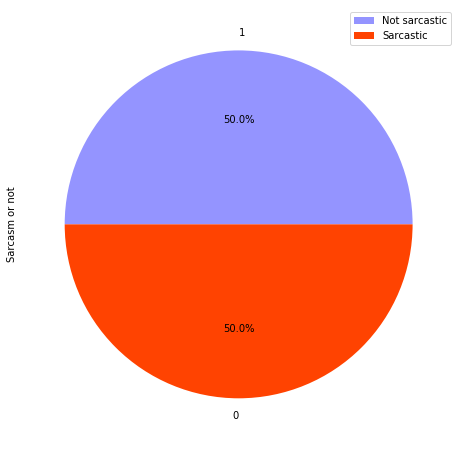

In [16]:
trb['label'].value_counts().plot(kind = 'pie', figsize = (8, 8), autopct = '%1.1f%%', colors = ['#9494FF', '#FF4301'])
plt.ylabel('Sarcasm or not')
plt.legend(['Not sarcastic', 'Sarcastic'])
plt.savefig('pie.png')
plt.savefig('pie.pdf')

In [14]:
subs = trb.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
subs[subs['size'] > 500].sort_values(by = 'mean', ascending = False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
progun,541,0.709797,384
rage,886,0.697517,618
MensRights,3356,0.680870,2285
Bad_Cop_No_Donut,902,0.678492,612
ShitRedditSays,1284,0.661994,850
niceguys,910,0.653846,595
conspiratard,663,0.653092,433
worldnews,26377,0.642529,16948


In [62]:
red_dit_blue = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#9494FF', '#FF4301'])

In [16]:
wordcloud = WordCloud(background_color = 'white', width = 3840, height = 2160, min_font_size = 1, colormap = red_dit_blue)

In [ ]:
#trb.to_pickle('trb.pkl')

In [2]:
#trb = pd.read_pickle('trb.pkl')

## Raw

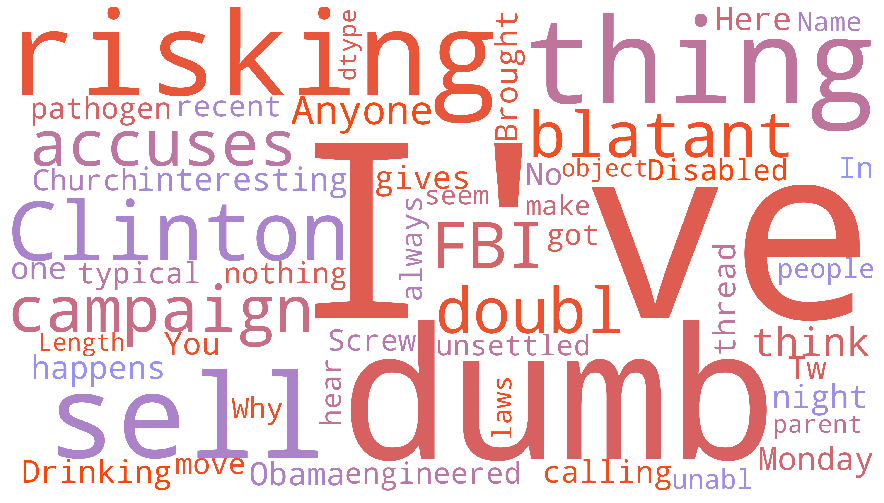

In [17]:
plt.figure(figsize = (16, 9))
wordcloud.generate(str(trb.loc[trb['label'] == 1, 'parent']))
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wc1.png')
plt.savefig('wc1.pdf')

In [72]:
y = trb['label']
x1 = trb['parent']
x2 = trb['subreddit']

In [5]:
tf_idf_par = TfidfVectorizer(ngram_range = (1, 2)) 
tf_idf_sub = TfidfVectorizer(ngram_range = (1, 1))
lgt = LogisticRegression(C = 1, n_jobs = -1, solver = 'lbfgs', random_state = 42, verbose = 1)

In [74]:
%%time 
X_par = tf_idf_par.fit_transform(x1)
X_sub = tf_idf_sub.fit_transform(x2)

Wall time: 1min 23s


In [75]:
X = hstack([X_par, X_sub])

In [25]:
#Logit
parlgt = np.mean(cross_val_score(lgt, X, y, n_jobs = -1))
parlgt

0.5912877202743936

In [12]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()

In [8]:
#Naive Bayes
parnb = np.mean(cross_val_score(NB, X, y, n_jobs = -1))
parnb

0.5942931824855989

## Stemming and stopwords

In [6]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

stemmer = SnowballStemmer("english")

def cleanText(x):
    
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    
    return " ".join(words)

In [ ]:
trb['stemstop'] = trb['parent'].apply(cleanText)

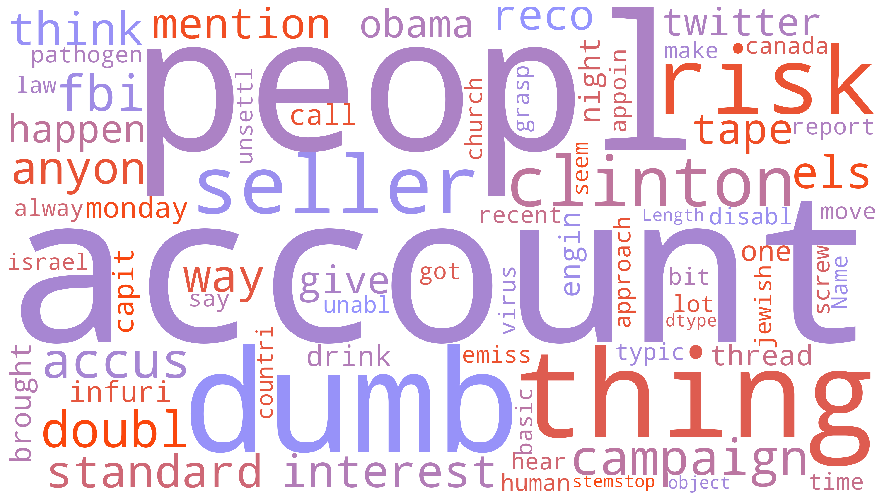

In [28]:
plt.figure(figsize = (16, 9))
wordcloud.generate(str(trb.loc[trb['label'] == 1, 'stemstop']))
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wc2.png')
plt.savefig('wc2.pdf')

In [11]:
x1 = trb['stemstop']

In [12]:
%%time 
X_par = tf_idf_par.fit_transform(x1)

Wall time: 55 s


In [13]:
X = hstack([X_par, X_sub])

In [32]:
#Logit
stemstoplgt = np.mean(cross_val_score(lgt, X, y, n_jobs = -1))
stemstoplgt

0.5841183345239652

In [14]:
#Naive Bayes
stemstopnb = np.mean(cross_val_score(NB, X, y, n_jobs = -1))
stemstopnb

0.5873374846370086

## Stemming

In [33]:
def cleanText2(x):
    
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha()]
    
    return " ".join(words)

In [ ]:
trb['stem'] = trb['parent'].apply(cleanText2)

In [3]:
trb.head()

,label,subreddit,parent,stemstop,stem
0,0,politics,"Yeah, I get that argument. At this point, I'd ...",yeah get argument point prefer live nc well,yeah i get that argument at this point i prefe...
1,0,nba,The blazers and Mavericks (The wests 5 and 6 s...,blazer maverick west seed even carri good enou...,the blazer and maverick the west and seed did ...
2,0,nfl,They're favored to win.,favor win,they favor to win
3,0,BlackPeopleTwitter,deadass don't kill my buzz,deadass kill buzz,deadass do kill my buzz
4,0,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...,yep confirm saw tool use made boy,yep can confirm i saw the tool they use for th...


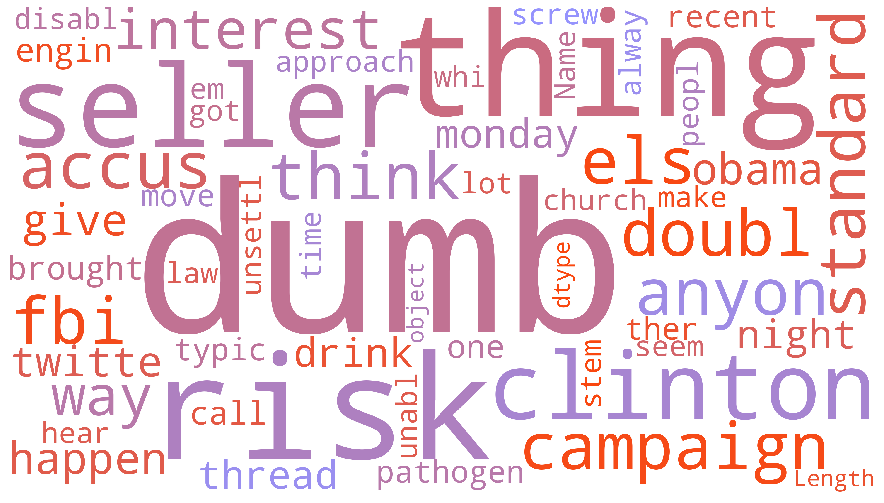

In [35]:
plt.figure(figsize = (16, 9))
wordcloud.generate(str(trb.loc[trb['label'] == 1, 'stem']))
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wc3.png')
plt.savefig('wc3.pdf')

In [3]:
x1 = trb['stem']

In [6]:
%%time 
X_par = tf_idf_par.fit_transform(x1)

Wall time: 1min 5s


In [10]:
X = hstack([X_par, X_sub])

In [39]:
#Logit
stemlgt = np.mean(cross_val_score(lgt, X, y, n_jobs = -1))
stemlgt

0.5909582864646342

In [41]:
#Naive Bayes
stemnb = np.mean(cross_val_score(NB, X, y))
stemnb

0.5938183228852901

In [15]:
from sklearn.svm import LinearSVC
SVM = LinearSVC(max_iter = 3000, random_state = 42)

In [16]:
#Support Vector Machine
stemsvm = np.mean(cross_val_score(SVM, X, y))
stemsvm

0.5716424007967985

In [9]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def cleanText3(x):
    
    words = [wordnet_lemmatizer.lemmatize(word, pos = 'v') for word in nltk.word_tokenize(x.lower()) if word.isalpha()]
    
    return " ".join(words)

In [10]:
trb['lem'] = trb['parent'].apply(cleanText3)

In [11]:
trb.head()

,label,subreddit,parent,stemstop,stem,lem
0,0,politics,"Yeah, I get that argument. At this point, I'd ...",yeah get argument point prefer live nc well,yeah i get that argument at this point i prefe...,yeah i get that argument at this point i prefe...
1,0,nba,The blazers and Mavericks (The wests 5 and 6 s...,blazer maverick west seed even carri good enou...,the blazer and maverick the west and seed did ...,the blazers and mavericks the wests and seed d...
2,0,nfl,They're favored to win.,favor win,they favor to win,they favor to win
3,0,BlackPeopleTwitter,deadass don't kill my buzz,deadass kill buzz,deadass do kill my buzz,deadass do kill my buzz
4,0,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...,yep confirm saw tool use made boy,yep can confirm i saw the tool they use for th...,yep can confirm i saw the tool they use for th...


In [13]:
y = trb['label']
x1 = trb['lem']
x2 = trb['subreddit']
tf_idf_par = TfidfVectorizer(ngram_range = (1, 2)) 
tf_idf_sub = TfidfVectorizer(ngram_range = (1, 1))
X_par = tf_idf_par.fit_transform(x1)
X_sub = tf_idf_sub.fit_transform(x2)
X = hstack([X_par, X_sub])

In [14]:
lemnb = np.mean(cross_val_score(NB, X, y, n_jobs = -1))
lemnb

0.5932831169887101

In [13]:
hv = [parlgt, parnb, stemstoplgt, stemstopnb, stemlgt, stemnb, stemsvm]
nc = ['parlgt', 'parnb', 'stemstoplgt', 'stemstopnb', 'stemlgt', 'stemnb', 'stemsvm']

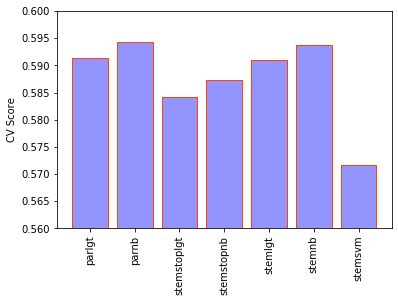

In [15]:
plt.bar(x = nc, height = hv, color = '#9494FF', edgecolor = '#FF4301')
plt.ylabel('CV Score')
plt.ylim((0.56, 0.6))
plt.xticks(rotation='vertical')
plt.savefig('hist.png')
plt.savefig('hist.pdf')

In [110]:
%%time
y = trb['label']
x1 = trb['parent']
x2 = trb['subreddit']
tf_idf_par = TfidfVectorizer(ngram_range = (1, 2)) 
tf_idf_sub = TfidfVectorizer(ngram_range = (1, 1))
X_par = tf_idf_par.fit_transform(x1)
X_sub = tf_idf_sub.fit_transform(x2)
X = hstack([X_par, X_sub])
NB.fit(X, y)

Wall time: 1min 17s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [111]:
d = {'subreddit': ['politics'], 'parent': ['Trump is very good']}
com = pd.DataFrame(d)
X_s = tf_idf_sub.transform(com['subreddit'])
X_p = tf_idf_par.transform(com['parent'])
X_n = hstack([X_p, X_s])

In [112]:
NB.predict_proba(X_n)

array([[0.38009797, 0.61990203]])